# Image Compression and Classification with PCA - code along

## Introduction
In the last lesson, we looked at how PCA plays an important role in the field of image processing by allowing us to compress and simplify high dimensional image data for faster processing and simplicity of analysis. In this code along, we shall look at applying these techniques to the popular MNIST dataset, before attempting to calculate Eigenfaces in the next lab. This code along style lab will introduce you to all the required steps which with an understanding of underlying mechanism.

## Objectives
You will be able to:
- Apply PCA to MNIST, or a similar image based dataset
- Inspect the effect of number of principal components on explained variance and vice versa, for image data.
- Run a classifier using PCA components and inspect the impact on classification accuracy

## MNIST DATASET

The MNIST dataset contains handwritten digits. MNIST is a popular labeled dataset for practicing image processing techniques and contains a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from [NIST](https://www.nist.gov/srd/nist-special-database-19). The digits have been size-normalized and centered in a fixed-size image. Here is sample of images that you would find in MNIST dataset. 

<img src="mnist.png" width=500>

This is an excellent dataset for aspiring data scientists, wanting to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

The MNIST database of handwritten digits is available on the following website: [MNIST Dataset](http://yann.lecun.com/exdb/mnist/). Do visit some of the provided links to see how researchers and practitioners are using this dataset for developing cutting machine learning algorithms in the domain of computer vision/image processing.


Parameters | Number
--- | ---
Classes | 10
Samples per class | ~7000 samples per class
Samples total | 70000
Dimensionality | 784
Features | integers values from 0 to 255

Let's load this dataset into our working environment. First we need the necessary libraries required for this experiment. 

### Import Necessary Libraries

```python
# Import necessary libraries 

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
```

In [5]:
# Import necessary libraries 

from sklearn.datasets import fetch_mldata
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Download and Inspect the Dataset

MNIST dataset can be downloaded with scikit-learn for experimentation. We shall use `fetch_mldata()` to import this dataset into our environment. 

```python
# Download the dataset
digits = fetch_mldata('MNIST original')
digits
```

In [11]:
# Download the dataset
digits = datasets.fetch_openml('mnist_784', version=1, cache=True)
digits

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixel49',
  'pixel50',
  'pixel51',
  '

The dataset contains both features (as digits.data) and target labels (as digits.target). Let's quickly check these for size. 

```python
# Features in MNIST
feat = digits.data
print('Features:', feat.shape)

# Targets in MNIST
target = digits.target
print('Target:', target.shape)
```

In [12]:
feat = digits.data
print('Features:', feat.shape)

target = digits.target
print('Target:', target.shape)

Features: (70000, 784)
Target: (70000,)


#### Viewing Images and labels in the dataset 
Above we can see that data is saved as arrays of 0/1 digits, following the digitization approach we saw in the previous lesson. We can visualize these arrays as images as shown below:

```python
# View the first image
first_image = digits.data[0]
first_image = np.array(first_image, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray_r')
plt.axis('off')
plt.show()
print ('Label:',digits.target[0])

# View last image 
last_image = digits.data[-1]
first_image = np.array(last_image, dtype='float')
pixels = last_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray_r')
plt.axis('off')
plt.show()
print ('Label:',digits.target[-1])

```

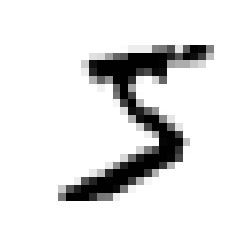

Label: 5


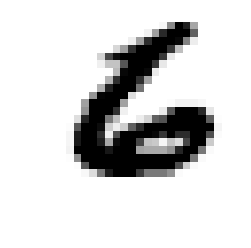

Label: 6


In [13]:
# view first image
first_image = digits.data[0]
first_image = np.array(first_image, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray_r')
plt.axis('off')
plt.show()
print('Label:', digits.target[0])

# view last image
last_image = digits.data[-1]
last_image = np.array(last_image, dtype='float')
pixels = last_image.reshape((28,28))
plt.imshow(pixels, cmap='gray_r')
plt.axis('off')
plt.show()
print('Label:', digits.target[-1])

Here we visualized the first and last image in the features dataset and pulled their labels for the target. 

### Feature Standardization

Just like any other other dataset, the first step in applying PCA is always normalization of data. We shall use the` StandardScaler()` from scikit-learn to standardize the features set. Remember, targets are just class labels and don't need any pre-processing. 

```python
from sklearn.preprocessing import StandardScaler
# Create a scalar instance 
scaler = StandardScaler()

# Fit the features only, labels dont need transformation
digits.data = scaler.fit_transform(digits.data)
```

In [15]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(digits.data)

digits.data = ss.transform(digits.data)

### PCA with 95% Variance Retention

Earlier, we looked an instantiating PCA with a set number of components. We can also run a PCA while defining the required amount of variance that we expect our resulting principal components to retain. This can be passed in as a value from 0 (no variance) - 1 (100% variance). Let's try it with 95% variance retention with our data and see how many components we need.  

```python
# Perform PCA 
from sklearn.decomposition import PCA
pca = PCA(.95) # Retain 95% of the variance
digits_low_dim = pca.fit_transform(digits.data)
pca.n_components_ # Check number of components for required variance
```

In [16]:
from sklearn.decomposition import PCA
pca = PCA(0.95) # retain 95% of the variance
pca.fit(digits.data)
digits_low_dim = pca.transform(digits.data)
pca.n_components_ # number of components for required variance

332

So we need 332 components in total to explain 95% of variation in the data. Not a bad start. 

> __Going from 784 features to 332 components help reduce the running time of a supervised learning algorithm. We can also go from compressed representation back to an approximation of the original high dimensional data (784 components).__

### PCA - Inverse Transform (transforming low dimensional, data back to its original space)


We can compare an observations from before and after PCA to see if there is any loss in the quality of the image. `pca.inverse_transform()` method allows us to reconstruct the image achieve this goal. Visit [this link](https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com) for details on how this method works behind the scenes. 

> Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space

```python
# Reconstruct the original image 
reconstruction = pca.inverse_transform(digits_low_dim)
```

In [17]:
reconstruction = pca.inverse_transform(digits_low_dim)

#### So we can now view pre and post PCA data for a particular example in our dataset as shown below:
    
```python
    
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
plt.figure(figsize=(8,4));

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(feat[1].reshape(28,28))
plt.xlabel('784 components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 154 principal components
plt.subplot(1, 2, 2);
plt.imshow(reconstruction[1].reshape(28, 28))
plt.xlabel('332 components', fontsize = 14)
plt.title('95% of Explained Variance', fontsize = 20);
plt.show()
```

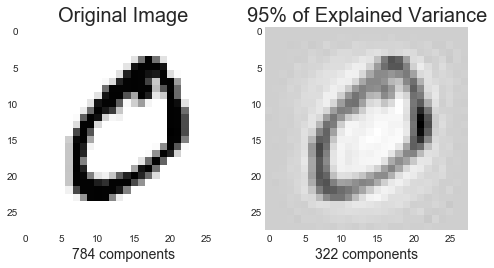

In [18]:
%matplotlib inline
plt.style.use('seaborn-dark')
plt.figure(figsize=(8,4))

# original
plt.subplot(1, 2, 1)
plt.imshow(feat[1].reshape(28,28))
plt.xlabel('784 components', fontsize=14)
plt.title('Original Image', fontsize=20)

# 322 PCs
plt.subplot(1, 2, 2)
plt.imshow(reconstruction[1].reshape(28,28))
plt.xlabel('322 components', fontsize=14)
plt.title('95% of Explained Variance', fontsize=20)
plt.show()

Above, we can see that even with such a huge reduction in the number of features, the the image is still maintaining most of its identifying characteristics. There is some noise apparent in the data as a result of this. However, we will shortly see that for classification purpose, it doesn't harm the analysis too much. 

## Simulation for Explained Variance vs. Number of components

In order to see how variance and numbers of components relate to each other, we can calculate variance explained with respect to number of components. Such analysis could be a useful way to get an objective indication on how much dimensionality reduction can we perform, and at what cost in terms of variance retention. 

Let's run another instance of PCA without specifying the dimensions or variance as shown below:

```python
# if n_components is not set all components are kept (784 in this case)
pca = PCA()
pca.fit(digits.data)
pca.n_components_
```

In [19]:
pca = PCA()
pca.fit(digits.data)
pca.n_components_

784

So the number of components here is exactly the same as number of features in the original dataset as expected. Let's calculate the total variance explained by these 784 components. 

```python
# Summing explained variance
tot = sum(pca.explained_variance_)
tot
```

In [21]:
tot = sum(pca.explained_variance_)
tot

719.010271575308

We see a huge numbers here. That is because the variance is not normalized in this case. We can normalize each variance value explained by individual components and normalize it as below:
```python
# Normalized explained variance
var_exp = [(i/tot)*100 for i in sorted(pca.explained_variance_, reverse=True)] 
print(var_exp[0:5])
sum(var_exp)
```

In [22]:
var_exp = [(i/tot)*100 for i in sorted(pca.explained_variance_, reverse=True)]
print(var_exp[0:5])
sum(var_exp)

[5.642718902619974, 4.041225876161669, 3.7382733314866656, 2.8929996703158882, 2.5207517581331493]


100.00000000000009

This looks much better. Our values show a percentage of variance explained. Also `reverse=True` arranges these values in a descending order. Now we can calculate the cumulative variance as we add more dimensions , starting from 1 and going all the way to 784. We can use numpy's `cumsum()` to achieve this. 

```python
# Cumulative explained variance
cum_var_exp = np.cumsum(var_exp) 
plt.style.use('ggplot')
plt.figure(figsize=(15, 8))
plt.plot(cum_var_exp)
plt.title('Cumulative Explained Variance as a Function of the Number of Components');
```

Text(0.5, 1.0, 'Cumulative Explained Variance as a Function of the Number of Components')

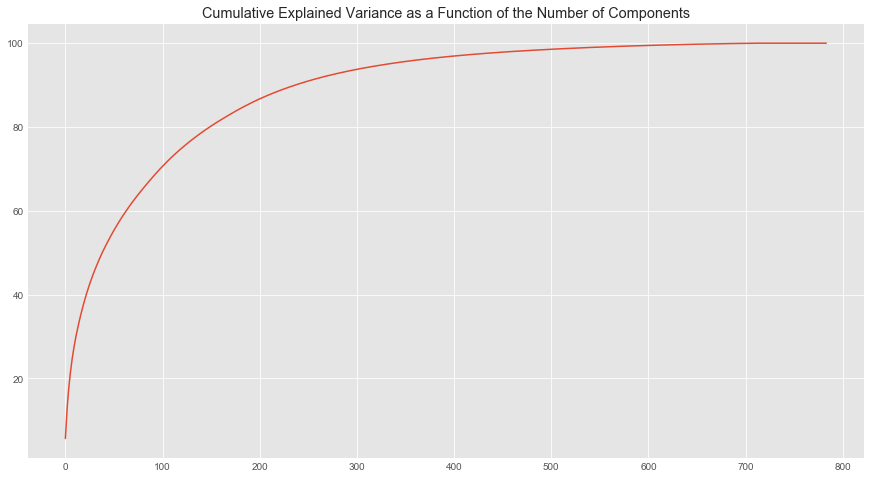

In [23]:
cum_var_exp = np.cumsum(var_exp)
plt.style.use('ggplot')
plt.figure(figsize=(15,8))
plt.plot(cum_var_exp)
plt.title('Cumulative Explained Variance as a Function of the Number of Components')

Above we see a cumulative function for variance explained with respect to number of components. Let's add a bit more information to this plot and make it more meaningful. 

```python
# Cumulative Variance w.r.t. number of components
plt.style.use('ggplot')
plt.figure(figsize=(15, 8))
plt.step(range(1, 785), cum_var_exp, where='mid',label='Cumulative Explained Variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.axhline(y = 90, color='c', linestyle='--', label = '90% Explained Variance')
plt.axhline(y = 85, color='r', linestyle='--', label = '85% Explained Variance')
plt.legend()
plt.show()
```

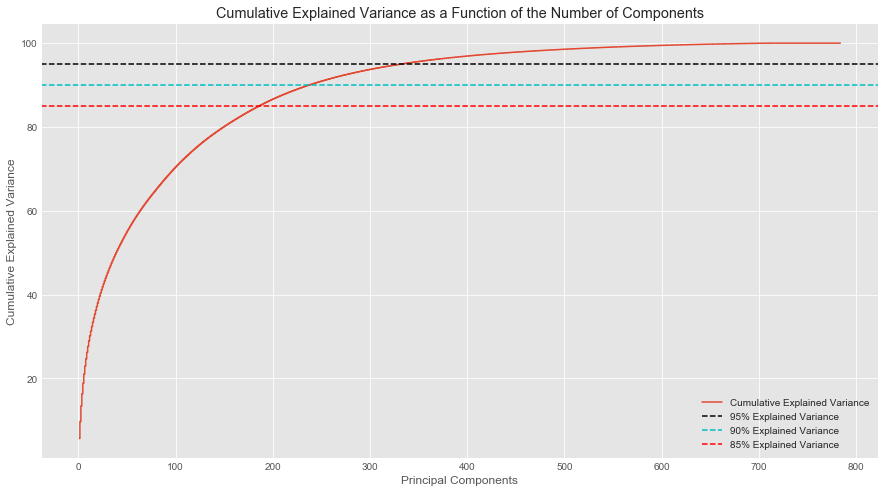

In [24]:
plt.figure(figsize=(15,8))
plt.step(range(1,785), cum_var_exp, where='mid', label='Cumulative Explained Variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Principal Components')
plt.axhline(y=95, color='k', linestyle='--', label='95% Explained Variance')
plt.axhline(y=90, color='c', linestyle='--', label='90% Explained Variance')
plt.axhline(y=85, color='r', linestyle='--', label='85% Explained Variance')
plt.legend()
plt.show()

This explains a lot. We need around 238 components to explain 90% of varaince. Around 150 components for 80% variance , and so on. Let's get an idea about components required for a number of variance values, so we can visually inspect how components and variance relates to the appearance of images in the dataset. 

We can check our cumulative function for any particular variance value and see how many components do we need. Let's check this for 99%, 95%, 90%, and 85% of Explained Variance
```python
# check number of components for given explained variance
componentsVariance = [784, np.argmax(cum_var_exp > 99) + 1, 
                      np.argmax(cum_var_exp > 95) + 1, 
                      np.argmax(cum_var_exp > 90) + 1, 
                      np.argmax(cum_var_exp >= 85) + 1] # Adding one as index starts from 0.
componentsVariance
```

In [25]:
componentsVariance = [784, np.argmax(cum_var_exp > 99) + 1,
                      np.argmax(cum_var_exp > 95) + 1,
                      np.argmax(cum_var_exp > 90) + 1, 
                      np.argmax(cum_var_exp >= 85) + 1]
componentsVariance

[784, 544, 332, 238, 186]

## Visualize PCA Images 

So how does all of above actually effect the visual aspect of the image. Let's write a simple function that accept percentage variance required with the image dataset to run PCA and return the images post-PCA. 

```python
# Run PCA on a given dataset with explained variance
n_comp = 0 # For storing current number of components

def explainedVariance(percentage, images): 
    global n_comp # write global variable
    
    # percentage should be a decimal from 0 to 1 
    pca = PCA(percentage)
    pca.fit(images)
    components = pca.transform(images)
    # Apply inverse transform as seen above
    approxOriginal = pca.inverse_transform(components)
    n_comp = pca.n_components_
    return approxOriginal
```

In [27]:
n_comp = 0

def explainedVariance(percentage, images):
    global n_comp
    
    pca = PCA(percentage)
    pca.fit(images)
    components = pca.transform(images)
    
    approx_original = pca.inverse_transform(components)
    n_comp = pca.n_components_
    return approx_original

Now we can call this function repeatedly with defined explained variance values and select an image to inspect the impact of component count on how the images appears. 

```python
# Show image quality loss with respect to reduction in principal components
plt.style.use('seaborn-dark')
plt.figure(figsize=(20,4));

# Original Image (784 components)
plt.subplot(1, 5, 1);
plt.imshow(digits.data[-1].reshape(28,28));
plt.xlabel('784 Components', fontsize = 12)
plt.title('Original Image', fontsize = 14);

plt.subplot(1, 5, 2);
plt.imshow(explainedVariance(.99, digits.data)[-1].reshape(28, 28));
plt.title('99% of Explained Variance', fontsize = 14);
plt.xlabel(str(n_comp)+ ' Components')

plt.subplot(1, 5, 3);
plt.imshow(explainedVariance(.95, digits.data)[-1].reshape(28, 28));
plt.title('95% of Explained Variance', fontsize = 14);
plt.xlabel(str(n_comp)+ ' Components')

plt.subplot(1, 5, 4);
plt.imshow(explainedVariance(.90, digits.data)[-1].reshape(28, 28));
plt.title('90% of Explained Variance', fontsize = 14);
plt.xlabel(str(n_comp)+ ' Components')

plt.subplot(1, 5, 5);
plt.imshow(explainedVariance(.85, digits.data)[-1].reshape(28, 28));
plt.title('85% of Explained Variance', fontsize = 14);
plt.xlabel(str(n_comp)+ ' Components')
```

Text(0.5, 0, '3 Components')

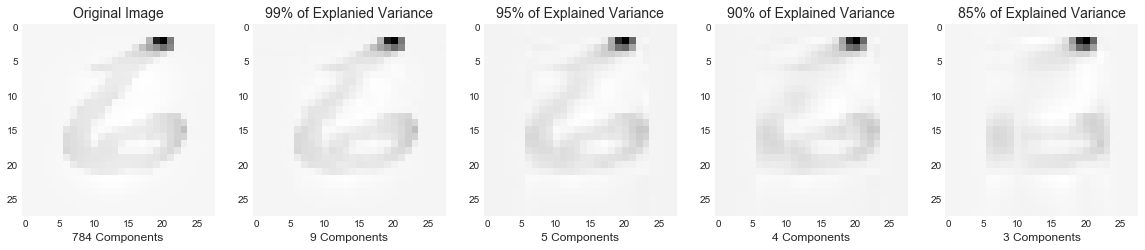

In [31]:
plt.style.use('seaborn-dark')
plt.figure(figsize=(20,4))

plt.subplot(1, 5, 1)
plt.imshow(digits.data[-1].reshape(28,28))
plt.xlabel('784 Components', fontsize=12)
plt.title('Original Image', fontsize=14)

plt.subplot(1,5,2)
plt.imshow(explainedVariance(.99, digits.data[-1].reshape(28,28)))
plt.title('99% of Explanied Variance', fontsize=14)
plt.xlabel(str(n_comp) + ' Components')

plt.subplot(1, 5, 3);
plt.imshow(explainedVariance(.95, digits.data[-1].reshape(28, 28)))
plt.title('95% of Explained Variance', fontsize = 14)
plt.xlabel(str(n_comp)+ ' Components')

plt.subplot(1, 5, 4);
plt.imshow(explainedVariance(.90, digits.data[-1].reshape(28, 28)))
plt.title('90% of Explained Variance', fontsize = 14)
plt.xlabel(str(n_comp)+ ' Components')

plt.subplot(1, 5, 5);
plt.imshow(explainedVariance(.85, digits.data[-1].reshape(28, 28)))
plt.title('85% of Explained Variance', fontsize = 14)
plt.xlabel(str(n_comp)+ ' Components')

Here we see what "visually" happenes to the image as we reduce the number of components. Try running above routine again and check for lower values of explained variance. Also, check for different digits randomly from the dataset. This helps you make an informed decision about the quality-speed trade off. 

Visually, we may still be able to identify a 9 or any other digit. The real test here would be to pass this image data to a classifier and see how it performs. Let's try this with a simple multinomial logistic regression classifier next. 

## Classifying Images using Learned Components 

Following the standard supervised learning practice, we shall split our data into train and test sets using a 75/25 split. You can try different split levels and see how it impacts the performance. 

```python
# Create training and test datasets from standardized data 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25, random_state=10)
```

In [32]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25, random_state=10)

### Apply PCA as a preprocessing technique

We can now apply PCA on the training dataset while keeping 90% of explained variance. Again, you should try different values and study the impact on the outcome.

```python
# Run PCA with 90% explained variance
from sklearn.decomposition import PCA
pca = PCA(.90) # Retain 95% of the variance
pca.fit(X_train)from 
pca.n_components_
```

In [33]:
pca = PCA(0.9)
pca.fit(X_train)
pca.n_components_

229

We can now create our transformed training and test sets for logistic regression classifier as shown below:

```python
# Run a logistic regression classifier on transformed datasets
from sklearn.linear_model import LogisticRegression

# Create transformed test and train sets 
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# default solver is incredibly slow thats why we change it to solver = 'lbfgs' (Broyden–Fletcher–Goldfarb–Shanno algorithm)

logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(X_train, y_train)
```

In [34]:
from sklearn.linear_model import LogisticRegression

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kaylischulz/anaconda3/envs/lea

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

### Make predictions and Check Performance

Great, we can now try to predict the label for a given example in the test set as shown below:
```python
# Predict for a random Observation (image)
logisticRegr.predict(X_test[0].reshape(1,-1)) # predict the label of first image in transformed test set
```

In [35]:
logreg.predict(X_test[0].reshape(1,-1))

array(['6'], dtype=object)

Now we can check for the actual label in our target test set. 
```python
# View label from target 
y_test[0]
```

In [36]:
y_test[0]

'6'

Similarly we can try a sequence of images and get the labels as shown below  
```python
# Get labels for a random sequence of images
list(zip(logisticRegr.predict(X_test[0:10]), y_test)) 
```

In [37]:
list(zip(logreg.predict(X_test[0:10]), y_test))

[('6', '6'),
 ('7', '7'),
 ('5', '5'),
 ('7', '7'),
 ('8', '8'),
 ('0', '0'),
 ('3', '3'),
 ('4', '4'),
 ('2', '7'),
 ('2', '2')]

So far so good. All predicted labels are exactly same as the ground truth. To get an over all objective assessment of this classification, we can calculate the classification score using the built in method as below:
```python
# Calculate the classification score 
score = logisticRegr.score(X_test, y_test)
print(score)
```

In [38]:
score = logreg.score(X_test, y_test)
print(score)

0.9162285714285714


So we have 91% accuracy, with 229 components. This sounds great. We have managed to compress our data from 700+ features to just 229 components (1/3 of original data and can still achieve a high level of classification accuracy. We have run above experiments with classifiers mostly in their vanilla settings. Fine tuning and optimization techniques may help us increase this score. 

## Level up - Optional 

- Change the code above and calculate components, time taken and classification score for explained variance as shown in the table below. Fill the outcomes in the given table. 

```

Variance 	Number of       Time (seconds)      Score
Retained    Components

1.00	
0.95	
0.90	
0.85	
0.80
0.70
```
- Run the experiment without standardization and record your observations.
- Try other classifiers that you are familiar with to study the impact on PCA on each. 

## Summary 

In this code along, we looked at the role of PCA in basic image processing with MNIST dataset. Image datasets tend to be very large in size and PCA allows us to use a compressed (or reduced) representation of image data to fulfil the analyses needs. Next, we shall see how these techniques may be applied to slightly more complex image data i.e. human faces with Eigenfaces. 